In [1]:
## PROJECTS Unsupervised Machine Learning
## Uber Pickups

In [2]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import  silhouette_score
from datetime import datetime

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
import seaborn as sn
pio.renderers.default = "vscode"

In [3]:
#### uber-raw-data-apr14
data_01 = pd.read_csv("Resources/uber-raw-data-apr14.csv")
data_01.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [4]:
# Voir les variables avec des données vident
data_01.isnull().sum()

Date/Time    0
Lat          0
Lon          0
Base         0
dtype: int64

## Trie des dates 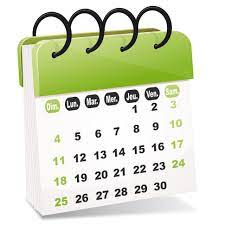

In [5]:
# Convertir la chaîne de caractères en objet datetime
data_01['Date/Time'] = pd.to_datetime(data_01['Date/Time'])

# Extraire l'année, le mois, le jour et le jour de la semaine
data_01['Date'] = data_01['Date/Time'].dt.date
data_01['Time'] = data_01['Date/Time'].dt.time

In [6]:
# Drop la colonne Date/Time
data_01 = data_01.drop(columns = ['Date/Time'])
data_01.head()

,Lat,Lon,Base,Date,Time
0,40.7690,-73.9549,B02512,2014-04-01,00:11:00
1,40.7267,-74.0345,B02512,2014-04-01,00:17:00
2,40.7316,-73.9873,B02512,2014-04-01,00:21:00
3,40.7588,-73.9776,B02512,2014-04-01,00:28:00
4,40.7594,-73.9722,B02512,2014-04-01,00:33:00


In [7]:
# Convertir la chaîne de caractères en objet datetime
data_01['Date'] = pd.to_datetime(data_01['Date'])

# Extraire les jours de la semaine 
data_01['Dayofweek'] = data_01['Date'].dt.dayofweek
data_01.head()

,Lat,Lon,Base,Date,Time,Dayofweek
0,40.7690,-73.9549,B02512,2014-04-01,00:11:00,1
1,40.7267,-74.0345,B02512,2014-04-01,00:17:00,1
2,40.7316,-73.9873,B02512,2014-04-01,00:21:00,1
3,40.7588,-73.9776,B02512,2014-04-01,00:28:00,1
4,40.7594,-73.9722,B02512,2014-04-01,00:33:00,1


In [8]:
# Voir la distribution de la nouvelle colonne "Cat"
data = data_01['Dayofweek'].value_counts()
data

Dayofweek
2    108631
1     91185
4     90303
3     85067
5     77218
0     60861
6     51251
Name: count, dtype: int64

## Trie des heures 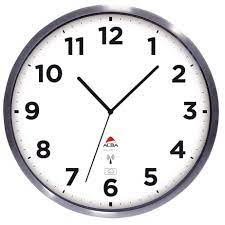

In [9]:
# Fonction pour attribuer une lettre en fonction de l'heure
def assign_letter(hour):
    if hour < 6:
        return 'A'
    elif hour < 12:
        return 'B'
    elif hour < 18:
        return 'C'
    else:
        return 'D'

In [10]:
# Ajout de la colonne "Cat" avec les lettres attribuées
data_01['Cat_Time'] = data_01['Time'].apply(lambda x: assign_letter(x.hour))
data_01.head()

,Lat,Lon,Base,Date,Time,Dayofweek,Cat_Time
0,40.7690,-73.9549,B02512,2014-04-01,00:11:00,1,A
1,40.7267,-74.0345,B02512,2014-04-01,00:17:00,1,A
2,40.7316,-73.9873,B02512,2014-04-01,00:21:00,1,A
3,40.7588,-73.9776,B02512,2014-04-01,00:28:00,1,A
4,40.7594,-73.9722,B02512,2014-04-01,00:33:00,1,A


In [11]:
# Distribution de la nouvelle colonne "Cat"
data = data_01['Cat_Time'].value_counts()
data

Cat_Time
D    206428
C    192020
B    120843
A     45225
Name: count, dtype: int64

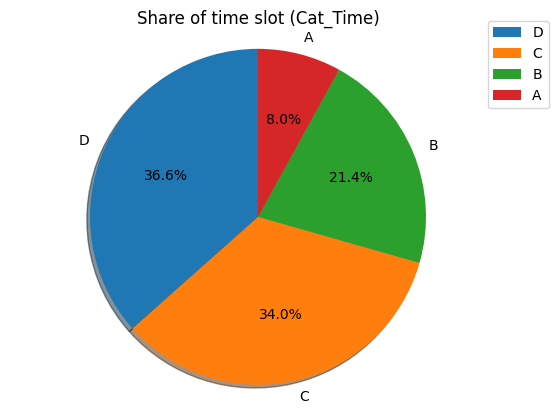

In [12]:
# Voir la distribution de la nouvelle colonne "Cat" en graphique
### "A" 00H00 / 06H00  -- "B" 06H00 / 12H00  -- "C" 12H00 / 18H00  -- "D" 18H00 / 00H00
plt.figure()
plt.pie(data.values, labels=data.index,
       autopct='%1.1f%%',
       shadow=True,
       startangle=90,
       radius=1.5
       )
plt.axis('equal')
plt.title('Share of time slot (Cat_Time)')
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

## Test de K-mean avec les "Dayofweek=0" soit lundi et "cat_time=A" soit 00H00 / 06H00

In [16]:
# Filtrer les lignes avec Dayofweek=0 et Cat_Time='A'
data_01_filtered = data_01[(data_01['Dayofweek'] == 0) & (data_01['Cat_Time'] == 'A')]
data_01_filtered.head()

,Lat,Lon,Base,Date,Time,Dayofweek,Cat_Time
7785,40.7205,-73.9939,B02512,2014-04-07,00:31:00,0,A
7786,40.7407,-74.0077,B02512,2014-04-07,00:37:00,0,A
7787,40.7591,-73.9892,B02512,2014-04-07,00:50:00,0,A
7788,40.7419,-74.0034,B02512,2014-04-07,00:58:00,0,A
7789,40.7419,-74.0034,B02512,2014-04-07,01:27:00,0,A


In [23]:
# Distribution de la variable data_01_filtered
data_01_filtered.shape

(4228, 7)

In [ ]:
# Type des colonnes
data_01.info()

In [ ]:
# Convertissez la colonne d'heures en format datetime
data_01['Heure'] = pd.to_datetime(data_01['Heure'], format='%H:%M:%S')

In [ ]:
data_01.info()

In [ ]:
## Connaitre le nombre d'id unique (personne) par genre.
id_unique = data_01.groupby('Cat').value_counts()
id_unique

In [ ]:
# Créer des nouveaux DataFrames pour chaque valeur unique de la colonne "Cat"
nouveaux_dfs = {}
for cat, group in data_01.groupby('Cat'):
    nouveaux_dfs[cat] = group.drop(columns='Cat')

# Afficher les nouveaux DataFrames
for cat, df_cat in nouveaux_dfs.items():
    print(f"DataFrame pour Catégorie '{cat}':")
    print(df_cat)
    print()

In [ ]:
# Création de nouveau dataframe par "Cat"
data_01_A = nouveaux_dfs['A']
data_01_B = nouveaux_dfs['B']
data_01_C = nouveaux_dfs['C']
data_01_D = nouveaux_dfs['D']

In [ ]:
# Visualisation des dataframes
print("Dataframe data_01_A")
print(data_01_A)


print("Dataframe data_01_B")
print(data_01_B)


print("Dataframe data_01_C")
print(data_01_C)


print("Dataframe data_01_D")
print(data_01_D)

In [ ]:
#### Traitement de la "Cat" "A" 00H00 / 06H00

numeric_features = [0, 1] # Positions des colonnes quantitatives dans X
numeric_transformer = StandardScaler()

# Création du transformer pour les variables catégorielles
categorical_features = [2,3,4] # Positions des colonnes catégorielles dans X
categorical_transformer = OneHotEncoder(drop='first')

# On combine les transformers dans un ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Preprocessings sur le dataset
print("Preprocessing sur le train set...")
print(data_01_A.head())
X_A = preprocessor.fit_transform(data_01_A) # fit_transform !!
print('...Terminé.')
print(X_A[0:5, :])
print()

In [ ]:
# Utilisation de la méthode Elbow pour trouver le nombre optimal de clusters

wcss_A =  []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, n_init = "auto")
    kmeans.fit(X_A)
    wcss_A.append(kmeans.inertia_)
    
print(wcss_A)

In [ ]:
fig = px.line(x = range(2,11), y = wcss_A)
fig.show()

In [ ]:
# Utilisation du silhouette_score pour déterminer le nombre optimal de clusters
s_score_A = []
for i in range (2,11): 
    kmeans = KMeans(n_clusters= i, n_init = "auto")
    kmeans.fit(X_A)
    s_score_A.append(silhouette_score(X_A, kmeans.predict(X_A)))

print(s_score_A)

In [ ]:
# Affichage de scores en fonction du nombre de clusters
fig = px.bar(x = range(2,11), y = s_score_A)
fig.show()

In [ ]:
# On ré-entraîne un KMeans avec le nombre optimal de clusters
kmeans = KMeans(n_clusters= 3, n_init = "auto")
kmeans.fit(X_A)

In [ ]:
data_01_A.loc[:,'Cluster_KMeans'] = kmeans.predict(X_A)
data_01_A.head()

In [ ]:
# On utilise scatter_mapbox pour visualiser notre graphique
fig = px.scatter_mapbox(data_frame=data_01_A, lat='Lat', lon='Lon', color='Cluster_KMeans', mapbox_style="carto-positron")
fig.show()

In [ ]:
#### uber-raw-data-may14
data_02 = pd.read_csv("uber-raw-data-may14.csv")
data_02.head()

In [ ]:
# Convertir la chaîne de caractères en objet datetime
data_02['Date/Time'] = pd.to_datetime(data_02['Date/Time'])
# Extraire l'année, le mois, le jour et le jour de la semaine
data_02['date'] = data_02['Date/Time'].dt.date
data_02['heure'] = data_02['Date/Time'].dt.time

In [ ]:
# Extraire l'année, le mois, le jour et le jour de la semaine
data_02['date'] = data_02['Date/Time'].dt.date
data_02['heure'] = data_02['Date/Time'].dt.time

In [ ]:
# Drop la colonne Date
data_02 = data_02.drop(columns = ['Date/Time'])
data_02.head()

In [ ]:
#### uber-raw-data-jun14
data_03 = pd.read_csv("uber-raw-data-jun14.csv")
data_03.head()

In [ ]:
# Convertir la chaîne de caractères en objet datetime
data_03['Date/Time'] = pd.to_datetime(data_03['Date/Time'])
# Extraire l'année, le mois, le jour et le jour de la semaine
data_03['date'] = data_03['Date/Time'].dt.date
data_03['heure'] = data_03['Date/Time'].dt.time

In [ ]:
# Extraire l'année, le mois, le jour et le jour de la semaine
data_03['date'] = data_03['Date/Time'].dt.date
data_03['heure'] = data_03['Date/Time'].dt.time

In [ ]:
# Drop la colonne Date
data_03 = data_03.drop(columns = ['Date/Time'])
data_03.head()

In [ ]:
#### uber-raw-data-jul14
data_04 = pd.read_csv("uber-raw-data-jul14.csv")
data_04.head()

In [ ]:
# Convertir la chaîne de caractères en objet datetime
data_04['Date/Time'] = pd.to_datetime(data_04['Date/Time'])
# Extraire l'année, le mois, le jour et le jour de la semaine
data_04['date'] = data_04['Date/Time'].dt.date
data_04['heure'] = data_04['Date/Time'].dt.time

In [ ]:
# Extraire l'année, le mois, le jour et le jour de la semaine
data_04['date'] = data_04['Date/Time'].dt.date
data_04['heure'] = data_04['Date/Time'].dt.time

In [ ]:
# Drop la colonne Date
data_04 = data_04.drop(columns = ['Date/Time'])
data_04.head()

In [ ]:
#### uber-raw-data-jul14
data_05 = pd.read_csv("uber-raw-data-aug14.csv")
data_05.head()

In [ ]:
# Convertir la chaîne de caractères en objet datetime
data_05['Date/Time'] = pd.to_datetime(data_05['Date/Time'])
# Extraire l'année, le mois, le jour et le jour de la semaine
data_05['date'] = data_05['Date/Time'].dt.date
data_05['heure'] = data_05['Date/Time'].dt.time

In [ ]:
# Extraire l'année, le mois, le jour et le jour de la semaine
data_05['date'] = data_05['Date/Time'].dt.date
data_05['heure'] = data_05['Date/Time'].dt.time

In [ ]:
# Drop la colonne Date
data_05 = data_05.drop(columns = ['Date/Time'])
data_05.head()

In [ ]:
#### uber-raw-data-sep14
data_06 = pd.read_csv("uber-raw-data-sep14.csv")
data_06.head()

In [ ]:
# Convertir la chaîne de caractères en objet datetime
data_06['Date/Time'] = pd.to_datetime(data_06['Date/Time'])
# Extraire l'année, le mois, le jour et le jour de la semaine
data_06['date'] = data_06['Date/Time'].dt.date
data_06['heure'] = data_06['Date/Time'].dt.time

In [ ]:
# Extraire l'année, le mois, le jour et le jour de la semaine
data_06['date'] = data_06['Date/Time'].dt.date
data_06['heure'] = data_06['Date/Time'].dt.time

In [ ]:
# Drop la colonne Date
data_06 = data_06.drop(columns = ['Date/Time'])
data_06.head()

In [ ]:
#### uber-raw-data-janjune-15
data_07 = pd.read_csv("uber-raw-data-janjune-15.csv")
data_07.head()

In [ ]:
# Convertir la chaîne de caractères en objet datetime
data_07['Pickup_date'] = pd.to_datetime(data_07['Pickup_date'])
# Extraire l'année, le mois, le jour et le jour de la semaine
data_07['date'] = data_07['Pickup_date'].dt.date
data_07['heure'] = data_07['Pickup_date'].dt.time

In [ ]:
# Extraire l'année, le mois, le jour et le jour de la semaine
data_07['date'] = data_07['Pickup_date'].dt.date
data_07['heure'] = data_07['Pickup_date'].dt.time

In [ ]:
# Drop la colonne Date
data_07 = data_07.drop(columns = ['Pickup_date'])
data_07.head()